### This is my first (public) notebook of playing with pyspark

The goal of this notebook is to demonstrare a simple use case of:
1. using pyspark (python wrapper for spark) and access existing spark cluster
2. loading data into spark
3. accessing the data using the rdd-api, dataframe-api, and dataset-api
4. simple data exploration

I'll be using a sample of the gutenberg project - https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html

#### The settings I'm using here:
- spark: version 2.0.0
- python: 3.5

In [126]:
# First, let's import all the relevant packages
import pyspark #python wrapper for spark
#import urllib3 #ability to access data by url
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
#from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from collections import Counter #used to count the occorences of each item in numpy list

#%matplotlib notebook

In [ ]:
# link to existing spark cluster
sc.stop()
sc = pyspark.SparkContext(appName="spark-project")

(count: 50000, mean: 49.920593171238565, stdev: 10.00904654075272, max: 93.95067285665748, min: 9.449284379878563)


<IPython.core.display.Javascript object>


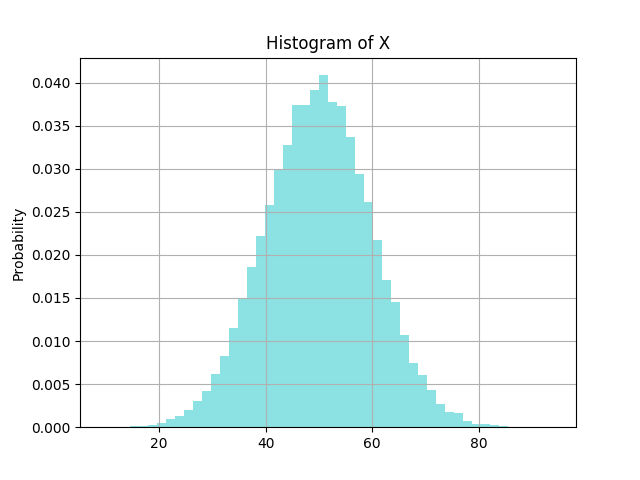

In [155]:
# First let's create a sample from the normal distribution
sample_size = 50000
students_grades = sc.parallelize(np.random.normal(loc=50,scale=10,size=sample_size))
print(students_grades.stats())
n, bins, patches = plt.hist(students_grades.collect(), bins=50, density=True, facecolor='c', alpha=0.45)
plt.ylabel('Probability')
plt.title('Histogram of X')
plt.grid(True)
plt.show()

In [ ]:
# Here we demonstrare a usage of the RDD API to read a text file
rdd = sc.textFile("s3n://ak-public-sandbox/datasets/gutenberg_dataset/1/8/*/*/*")
rdd.count()
rdd.take(1) 

In [ ]:
# Let's see some fitering capabilities
rdd.filter(lambda line: "French" in line).count()

In [ ]:
# The good-old word count example
term_freq = rdd.flatMap(lambda line: line.split(" ")).map(lambda word: (word,1)).reduceByKey(lambda a,b: a + b)
print("Total number of unique words %s" % term_freq.count())
stop_words = term_freq.takeOrdered(5,lambda a:-a[1])
rare_words = term_freq.takeOrdered(5,lambda a:a[1])
print("5 most frequent words: (word, freq): {0}".format(stop_words))
print("5 least frequent words: (word, freq) {0}".format(rare_words))

In [ ]:
# We count the number of occurences of each frequect (by value)
# For example, the term 'the' is the only which occured 37335, so we denote (37335,1).
count_per_freq = term_freq.map(lambda tf: (tf[1],1)).reduceByKey(lambda a,b: a+b)
# We use very simple bucketing, this is needed due to the collect call in the next cell - to avoid crashing the master node due to OOM
bucket_size = 50
binned_counter = count_per_freq.map(lambda freq: (freq[0] / bucket_size,freq[1])).reduceByKey(lambda a,b: a+b)

In [ ]:
# let's try to plot the (binned) frequency data, using log
num_bins = 100
n, bins, patches = plt.hist(binned_counter.values().collect(), num_bins, facecolor='b', normed=1,alpha=0.9)
plt.show()

In [ ]:
#ability to save the rdd directly as text file in s3
#rdd.saveAsTextFile("s3n://full/path/here")

In [ ]:
# basic usage of boto3
#import boto3
#session = boto3.Session() # leave out the profile_name argument if you haven't defined profiles
#s3 = boto3.resource('s3')
#bucket = s3.Bucket(bucket_name)
#objs = bucket.objects.filter(Prefix=some_prefix)
#for obj in objs:  
#  print(obj.key)
#obj = s3.Object(bucket_name, file_full_path_in_bucket)
#content = obj.get()["Body"].read().decode("utf-8")
#print(content[:300])